# Color Difference

In this notebook, we use color as an image descriptor to allow comparing images that contains AK wounds and normal skin. Histogram-based methods will be used using RGB and YIQ color spaces. 

In [1]:
from ipynb.fs.full.functools import Cases, np, plt, mpl
cases = Cases()
%matplotlib inline

##### AK before treatment

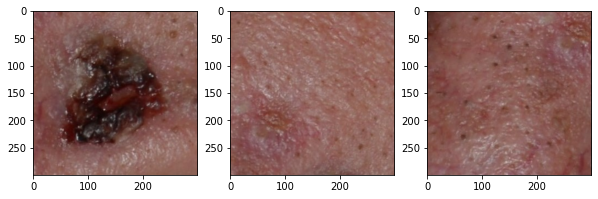

In [2]:
case = 'CASE141'

case_before = cases.before[case]

plt.figure(figsize=(10, 5))
plt.subplot(131); plt.imshow(case_before[0])
plt.subplot(132); plt.imshow(case_before[1])
plt.subplot(133); plt.imshow(case_before[2])
plt.show()

##### AK after treatment

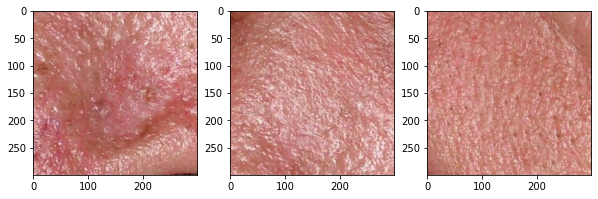

In [3]:
case_after = cases.after[case]

plt.figure(figsize=(10, 5))
plt.subplot(131); plt.imshow(case_after[0])
plt.subplot(132); plt.imshow(case_after[1])
plt.subplot(133); plt.imshow(case_after[2])
plt.show()

## Histograms

We want to define a method that gets any colour image as input and outputs a **vector** so that we are able to write distance functions between images in this space of colour attributes (features space) with m dimensions.

### RGB 
...

1. compute histogram and visualize them
2. compute the distance function (euclidean and log euclidean)
3. Normalize them for gray sclae output and perform steps 1-2

In [4]:
# use the histograms of all RGB channels
def global_histogram(img, bins, norm='sum', factor=512) -> np.ndarray:
    # single color channel
    if (len(img.shape) == 2):
        hist, _ = np.histogram(img, bins=bins)
    
    if (len(img.shape) == 3):
        hR,_ = np.histogram(img[:,:,0], bins=bins)
        hG,_ = np.histogram(img[:,:,1], bins=bins)
        hB,_ = np.histogram(img[:,:,2], bins=bins)
        hist = np.concatenate([hR, hG, hB])
        
    # normalizes histogram
    hist = hist.astype(float)
    
    if (norm == 'sum'):
        hist /= (hist.sum() + 1e-4)
        return hist
    
    hist /= (hist.sum() + 1e-4)
    hist *= factor
    return hist.astype(int)

In [5]:
def euclidean_distance(p, q):
    dist = np.sqrt(np.sum(np.square(p-q)))
    return dist

##### Using sum

In [6]:
num_bins = 32
selected_case = case_after

# compute the histograms of the case before treatment
rgbh_1 = global_histogram(img=selected_case[0], bins=num_bins)
rgbh_2 = global_histogram(img=selected_case[1], bins=num_bins)
rgbh_3 = global_histogram(img=selected_case[2], bins=num_bins)

print(f'The vector size is: {rgbh_1.shape}')

The vector size is: (96,)


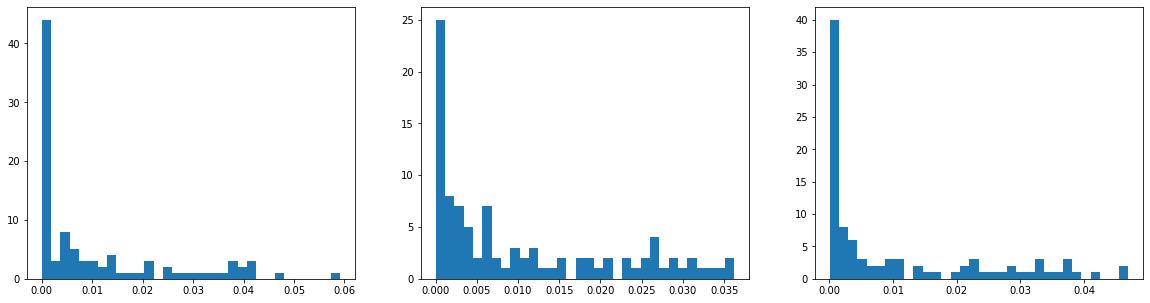

Distances for 32 bins:
Distance of 1-2 = 0.0915
Distance of 1-3 = 0.0999
Distance of 2-3 = 0.0365


In [7]:
# Plot the histograms
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.hist(rgbh_1, bins=num_bins)
plt.subplot(132); plt.hist(rgbh_2, bins=num_bins)
plt.subplot(133); plt.hist(rgbh_3, bins=num_bins)
plt.show()

# calculating the distances
print(f'Distances for {num_bins} bins:')
print("Distance of 1-2 = %.4f" % (euclidean_distance(rgbh_1, rgbh_2)))
print("Distance of 1-3 = %.4f" % (euclidean_distance(rgbh_1, rgbh_3)))
print("Distance of 2-3 = %.4f" % (euclidean_distance(rgbh_2, rgbh_3)))

Another aproach is to obtain a single channel from the RGB image. Converting them in a grayscale image. Luminance is used which is a weighted average of the colour channels

In [8]:
def normalize_minmax(f, factor):
    f_min = np.min(f)
    f_max = np.max(f)
    f = (f - f_min)/(f_max - f_min)
    return (f * factor)

def luminance(img):
    img = np.array(img, copy=True).astype(float)
    # convert
    new_img = np.zeros((img.shape[0], img.shape[1]))
#     new_img = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    new_img = img[:,:,0]*0.2126 + img[:,:,1]*0.7152 + img[:,:,2]*0.0722
    new_img = normalize_minmax(new_img, 255)
    return new_img

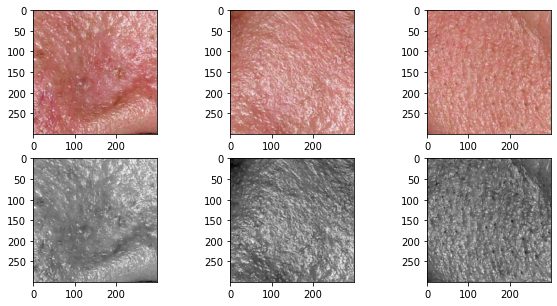

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(231); plt.imshow(selected_case[0])
plt.subplot(232); plt.imshow(selected_case[1])
plt.subplot(233); plt.imshow(selected_case[2])
plt.subplot(234); plt.imshow(luminance(selected_case[0]), cmap="gray")
plt.subplot(235); plt.imshow(luminance(selected_case[1]), cmap="gray")
plt.subplot(236); plt.imshow(luminance(selected_case[2]), cmap="gray")

plt.show()

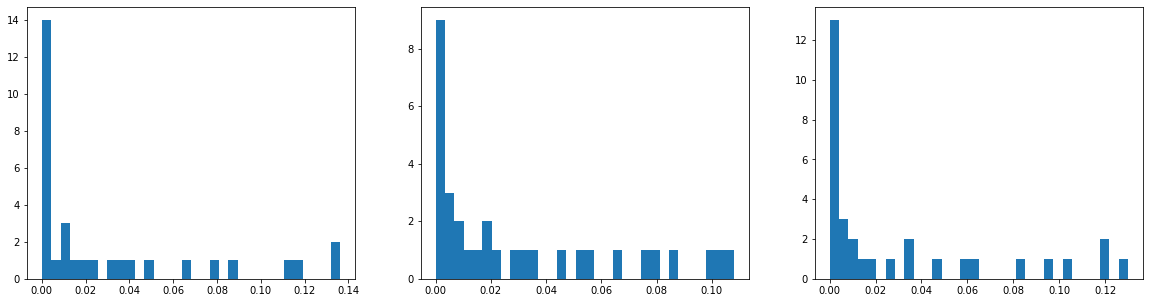

The vector size is: (32,)
Distance of 1-2 = 0.1587
Distance of 1-3 = 0.1799
Distance of 2-3 = 0.0499


In [10]:
gh_1 = global_histogram(img=luminance(selected_case[0]), bins=num_bins)
gh_2 = global_histogram(img=luminance(selected_case[1]), bins=num_bins)
gh_3 = global_histogram(img=luminance(selected_case[2]), bins=num_bins)

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.hist(gh_1, bins=num_bins)
plt.subplot(132); plt.hist(gh_2, bins=num_bins)
plt.subplot(133); plt.hist(gh_3, bins=num_bins)
plt.show()

print(f'The vector size is: {gh_1.shape}')

print("Distance of 1-2 = %.4f" % (euclidean_distance(gh_1, gh_2)))
print("Distance of 1-3 = %.4f" % (euclidean_distance(gh_1, gh_3)))
print("Distance of 2-3 = %.4f" % (euclidean_distance(gh_2, gh_3)))

### Decrease the influence of background colours.

The logarithm function may be useful for colour feature spaces

In [11]:
def log_euclidean_distance(p, q):
    pl = np.log2(p.astype(float) + 1)
    ql = np.log2(q.astype(float) + 1)
    dist = np.sqrt(np.sum(np.square(pl-ql)))
    return dist

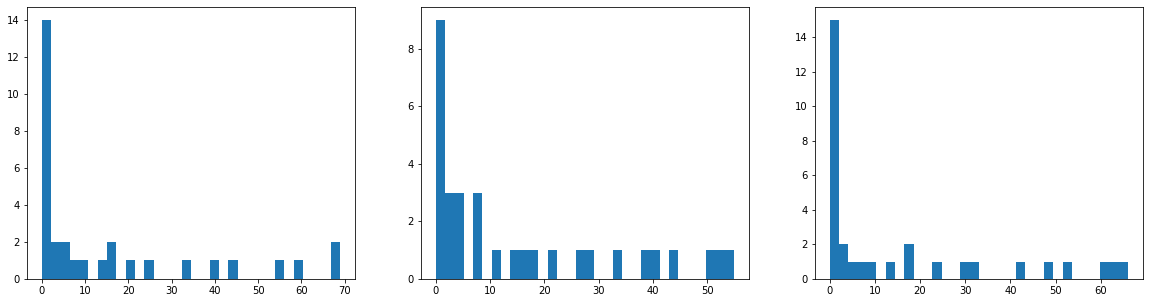

The vector size is: (32,)
Distance of 1-2 = 8.6926
Distance of 1-3 = 9.2531
Distance of 2-3 = 3.8858


In [12]:
gh_1 = global_histogram(luminance(selected_case[0]), bins=num_bins, norm="value")
gh_2 = global_histogram(luminance(selected_case[1]), bins=num_bins, norm="value")
gh_3 = global_histogram(luminance(selected_case[2]), bins=num_bins, norm="value")

plt.figure(figsize=(20, 5))
plt.subplot(131); plt.hist(gh_1, bins=num_bins)
plt.subplot(132); plt.hist(gh_2, bins=num_bins)
plt.subplot(133); plt.hist(gh_3, bins=num_bins)
plt.show()

print(f'The vector size is: {gh_1.shape}')

print("Distance of 1-2 = %.4f" % (log_euclidean_distance(gh_1, gh_2)))
print("Distance of 1-3 = %.4f" % (log_euclidean_distance(gh_1, gh_3)))
print("Distance of 2-3 = %.4f" % (log_euclidean_distance(gh_2, gh_3)))

### YIQ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


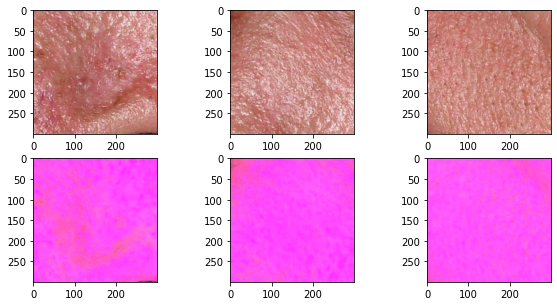

In [13]:
# transform images in YIQ using skimage

from skimage.color import yiq2rgb

case_yiq_before = [yiq2rgb(img) for img in selected_case]

plt.figure(figsize=(10, 5))
plt.subplot(231); plt.imshow(selected_case[0])
plt.subplot(232); plt.imshow(selected_case[1])
plt.subplot(233); plt.imshow(selected_case[2])
plt.subplot(234); plt.imshow(case_yiq_before[0])
plt.subplot(235); plt.imshow(case_yiq_before[1])
plt.subplot(236); plt.imshow(case_yiq_before[2])

plt.show()

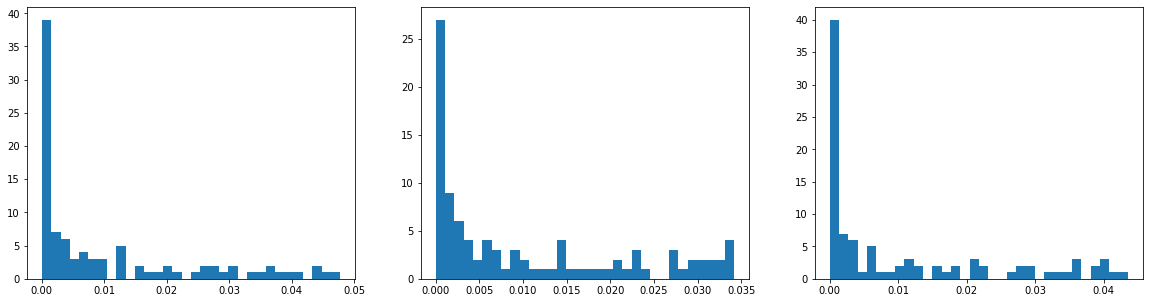

Distances for 32 bins:
Distance of 1-2 = 0.0870
Distance of 1-3 = 0.0669
Distance of 2-3 = 0.0562


In [14]:
yiqh_1 = global_histogram(img=case_yiq_before[0], bins=num_bins)
yiqh_2 = global_histogram(img=case_yiq_before[1], bins=num_bins)
yiqh_3 = global_histogram(img=case_yiq_before[2], bins=num_bins)

# Plot the histograms
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.hist(yiqh_1, bins=num_bins)
plt.subplot(132); plt.hist(yiqh_2, bins=num_bins)
plt.subplot(133); plt.hist(yiqh_3, bins=num_bins)
plt.show()

# calculating the distances/
print(f'Distances for {num_bins} bins:')
print("Distance of 1-2 = %.4f" % (euclidean_distance(yiqh_1, yiqh_2)))
print("Distance of 1-3 = %.4f" % (euclidean_distance(yiqh_1, yiqh_3)))
print("Distance of 2-3 = %.4f" % (euclidean_distance(yiqh_2, yiqh_3)))

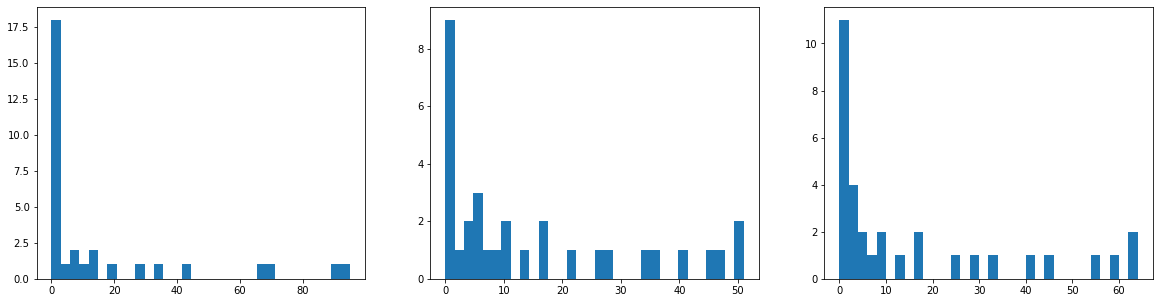

Distance of 1-2 = 13.4851
Distance of 1-3 = 12.5719
Distance of 2-3 = 3.6663


In [15]:
yiqh_1 = global_histogram(luminance(case_yiq_before[0]), bins=num_bins, norm="value")
yiqh_2 = global_histogram(luminance(case_yiq_before[1]), bins=num_bins, norm="value")
yiqh_3 = global_histogram(luminance(case_yiq_before[2]), bins=num_bins, norm="value")

# Plot the histograms
plt.figure(figsize=(20, 5))
plt.subplot(131); plt.hist(yiqh_1, bins=num_bins)
plt.subplot(132); plt.hist(yiqh_2, bins=num_bins)
plt.subplot(133); plt.hist(yiqh_3, bins=num_bins)
plt.show()

print("Distance of 1-2 = %.4f" % (log_euclidean_distance(yiqh_1, yiqh_2)))
print("Distance of 1-3 = %.4f" % (log_euclidean_distance(yiqh_1, yiqh_3)))
print("Distance of 2-3 = %.4f" % (log_euclidean_distance(yiqh_2, yiqh_3)))